In [1]:
import sys
import os
# Get the path of the directory containing the notebook file
notebook_dir = os.getcwd()
# Add the path to your Extra_code folder to the sys.path list
sys.path.append(os.path.join(notebook_dir, 'Extra_code'))
from utils_neuromaps_brain import * #from andrea santoro
import numpy as np
import tensorflow as tf
from nilearn.connectome import ConnectivityMeasure
from nilearn import plotting, datasets
import re
from scipy.stats import rankdata
from matplotlib import pyplot as plt
import seaborn as sns
#from sklearn.metrics import pairwise_distances
#from nltools.data import Adjacency
from nltools.stats import isc, _compute_matrix_correlation
import tensorflow as tf

In [2]:
def split_path_to_data(film, name_comparison="TC_14"):
    """Load data and separate it in 2
        return an array of all subject with their datapoints for all brain areas """
    file_name = os.listdir('data/'+film)
    all_path_to_14=[]
    all_path_to_400=[]
    for i in range(len(file_name)):
        path=(os.path.join('data/'+film, file_name[i]))
        condition=re.search(name_comparison,path)
        if (condition == None):
            all_path_to_400.append(path)
        else:
            all_path_to_14.append(path)
    return all_path_to_14, all_path_to_400

def load_data(name_comparison="TC_14", film='Rest' ):
    path14, path400 = split_path_to_data(film, name_comparison=name_comparison)
    data_all_subjects=[]
    for n in range (len(path14)):
        data14=np.genfromtxt(path14[n], delimiter=",")
        data400=np.genfromtxt(path400[n], delimiter=",")
        data_one_subject=np.concatenate([data400, data14], axis=1)
        data_all_subjects.append(data_one_subject)
    return data_all_subjects 

In [3]:
def compute_ISC(all_subjects_film, min_len):
    """Compute Pairwise Intersubject Correlations """
    #transform the data in a rectangular (same shape) array
    all=[]
    for i in range (len(all_subjects_film)):
        all.append(all_subjects_film[i][:min_len][:])

    
    tensor_subjects_film= tf.convert_to_tensor(all)
    #swap axes to be able to loop over brain regions
    tensor_subjects_film2=np.swapaxes(tensor_subjects_film,2,0)
    
    brain_region_ISC=[]
    for roi in range (400):
        brain_region_ISC.append(isc(tensor_subjects_film2[roi])['isc'])
    
    return brain_region_ISC


In [4]:
def compute_ISC_remove_noise(all_subjects_film, min_len):
    """Compute Pairwise Intersubject Correlations """
    #transform the data in a rectangular (same shape) array
    all=[]
    diff = min_len-min_len
    max_ = min_len - 75
    for i in range (len(all_subjects_film)):
        all.append(all_subjects_film[i][75:max_][:])
        
    tensor_subjects_film= tf.convert_to_tensor(all)
    #swap axes to be able to loop over brain regions
    tensor_subjects_film2=np.swapaxes(tensor_subjects_film,2,0)
    
    brain_region_ISC=[]
    for roi in range (400):
        brain_region_ISC.append(isc(tensor_subjects_film2[roi])['isc'])
    
    return brain_region_ISC

Parcellation with Sintel movie

In [5]:
all_subjects_Sintel=load_data(film='Sintel')
all_subjects_Sintel[0][:][:].shape, all_subjects_Sintel[1][:][:].shape, all_subjects_Sintel[2][:][:].shape, all_subjects_Sintel[3][:][:].shape, all_subjects_Sintel[4][:][:].shape

((712, 414), (710, 414), (710, 414), (712, 414), (710, 414))

In [6]:
brain_region_ISC_Sintel = compute_ISC(all_subjects_Sintel, 710)

findfont: Font family ['PT Serif Caption'] not found. Falling back to DejaVu Sans.


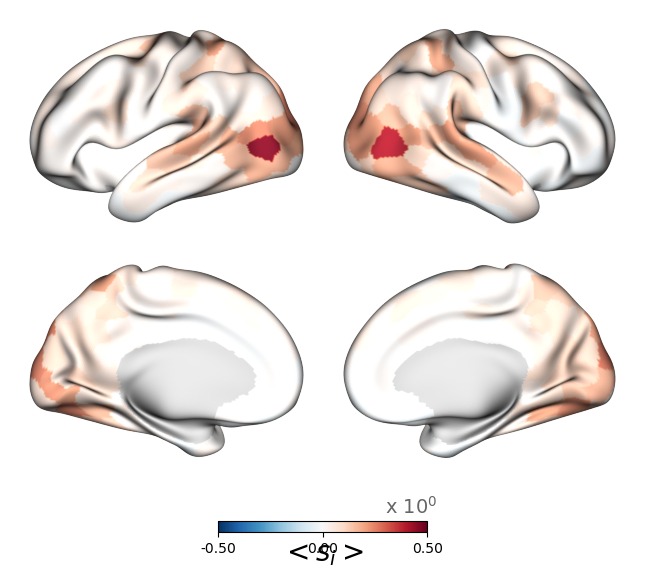

In [7]:
normal_view(brain_region_ISC_Sintel[:400], parcellation =400, vmin=-0.5, vmax=0.5)


Parcellation with Sintel movie without noise

In [8]:
brain_region_Sintel_no_noise = compute_ISC_remove_noise(all_subjects_Sintel, min_len=710)

findfont: Font family ['PT Serif Caption'] not found. Falling back to DejaVu Sans.
findfont: Font family ['PT Serif Caption'] not found. Falling back to DejaVu Sans.


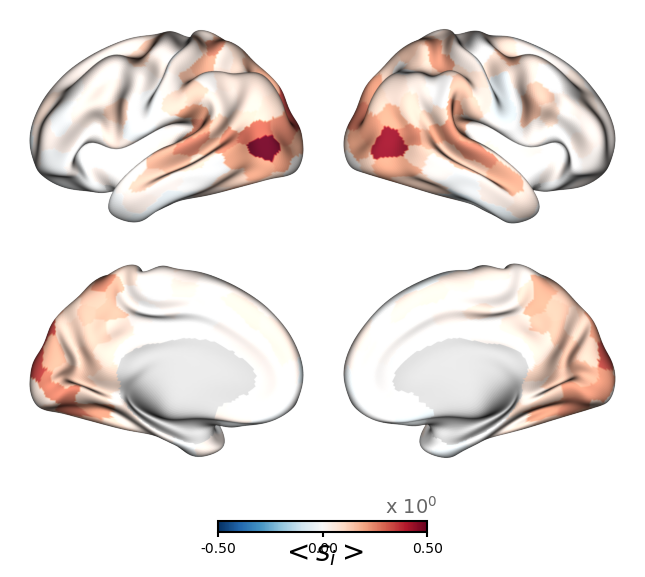

In [9]:
normal_view(brain_region_Sintel_no_noise[:400], parcellation =400, vmin=-0.5, vmax=0.5)

#vmin, vmax = symetrical 0.5, -0.5

Parcellation with The Secret Number

In [10]:
all_subjects_TSN=load_data(film='TheSecretNumber')
brain_region_TSN = compute_ISC(all_subjects_TSN, 758)

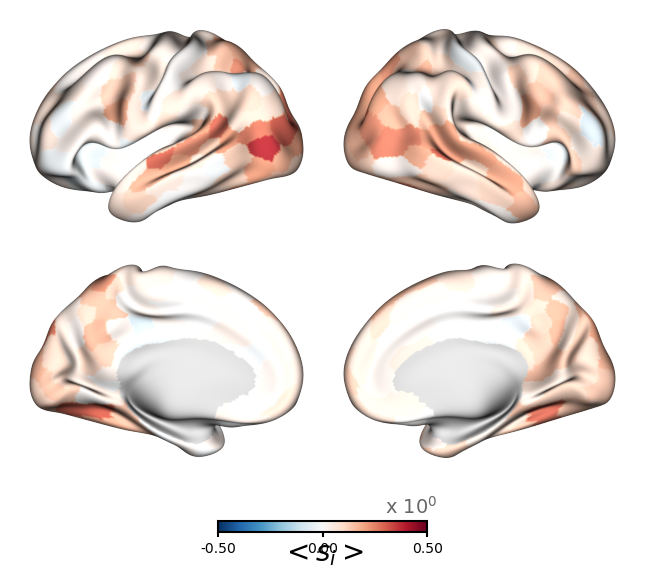

In [11]:
normal_view(brain_region_TSN[:400], parcellation =400, vmin=-0.5, vmax=0.5)

Similarity matrix and Connectome for one subject for Sintel

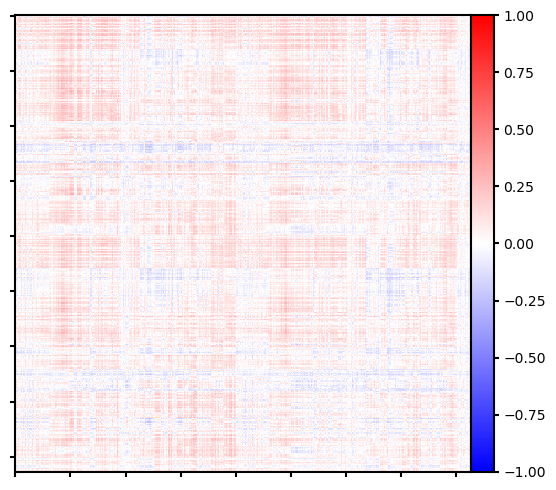

In [12]:
corr_Sintel=_compute_matrix_correlation(all_subjects_Sintel[1][:710][:], all_subjects_Sintel[3][:710][:])
plotting.plot_matrix(corr_Sintel, cmap=plotting.cm.bwr,vmin=-1, vmax=1)

In [13]:
dataset = datasets.fetch_atlas_schaefer_2018(n_rois=400, yeo_networks=7, resolution_mm=1, data_dir=None, base_url=None, resume=True, verbose=1)      
atlas_img = dataset.maps 
atlas_region_coords = plotting.find_parcellation_cut_coords(atlas_img)
labels = dataset.labels

c:\Users\gaell\anaconda3\lib\site-packages\nilearn\plotting\displays\_projectors.py:166: UserWarning: 'adjacency_matrix' is not symmetric. A directed graph will be plotted.
  warnings.warn(("'adjacency_matrix' is not symmetric. "
c:\Users\gaell\anaconda3\lib\site-packages\matplotlib\collections.py:981: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
findfont: Font family ['PT Serif Caption'] not found. Falling back to DejaVu Sans.
findfont: Font family ['PT Serif Caption'] not found. Falling back to DejaVu Sans.


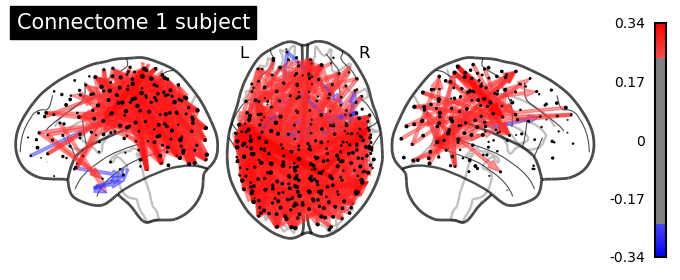

In [14]:
## diagonal to be used for node_size, however without a weight these will be so tiny they'll basically be invisible
diagonal = np.diagonal(corr_Sintel[:400,:400]) * 150
diagonal = np.diagonal(corr_Sintel[:400,:400]) * 20

plotting.plot_connectome(corr_Sintel[:400,:400], 
                            atlas_region_coords, 
                            node_size = diagonal, 
                             node_color = 'black',
                             edge_threshold='99.5%',
                             title="Connectome 1 subject",
                             display_mode="lzr",
                             colorbar = True,
                             edge_kwargs= {'linewidth': 1, 'alpha' : 0.5}
                             )
    
    
plotting.show()

Similarity matrix and Connectome for one subject for The Secret Number

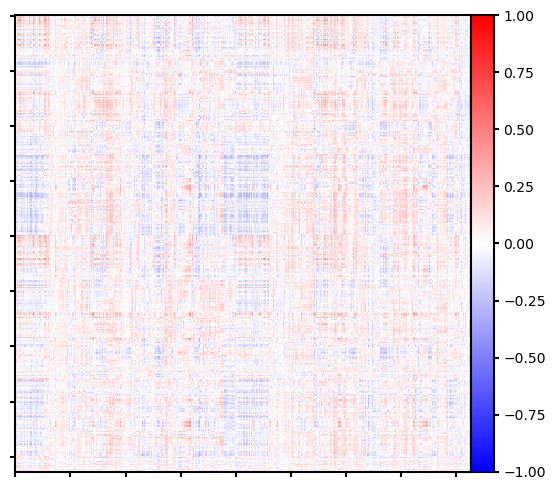

In [15]:
corr_TSN=_compute_matrix_correlation(all_subjects_TSN[0][:358][:], all_subjects_TSN[1][:358][:])
plotting.plot_matrix(corr_TSN, cmap=plotting.cm.bwr,vmin=-1, vmax=1)

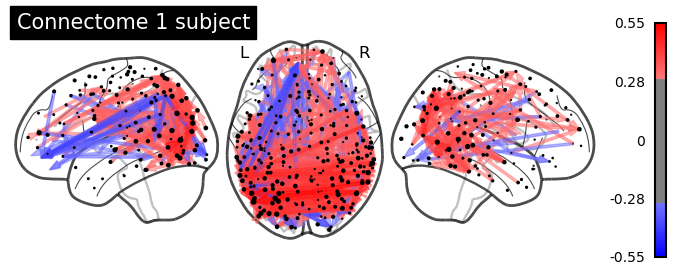

In [16]:
## diagonal to be used for node_size, however without a weight these will be so tiny they'll basically be invisible
diagonal = np.diagonal(corr_TSN[:400,:400]) * 150
diagonal = np.diagonal(corr_TSN[:400,:400]) * 20

plotting.plot_connectome(corr_TSN[:400,:400], 
                            atlas_region_coords, 
                            node_size = diagonal, 
                             node_color = 'black',
                             edge_threshold='99.5%',
                             title="Connectome 1 subject",
                             display_mode="lzr",
                             colorbar = True,
                             edge_kwargs= {'linewidth': 1, 'alpha' : 0.5}
                             )
    
    
plotting.show()